# Medic Proves they have PMQ and Receives GMC Licence


### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
import os
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://medic-agent:3021 and an api key of MyMedicalAPIKey


### Start a Webhook Server

In [3]:
webhook_port = os.getenv("WEBHOOK_PORT")
webhook_host = "0.0.0.0"

agent_controller.init_webhook_server(webhook_host, webhook_port)
await agent_controller.listen_webhooks()

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Register Agent Event Listeners

You can see some examples within the webhook_listeners recipe. Copy any relevant cells across and customise as needed.

In [4]:
listeners = []

# Receive connection messages
def connections_handler(payload):
    state = payload['state']
    connection_id = payload["connection_id"]
    their_role = payload["their_role"]
    routing_state = payload["routing_state"]
    
    print("----------------------------------------------------------")
    print("Connection Webhook Event Received")
    print("Connection ID : ", connection_id)
    print("State : ", state)
    print("Routing State : ", routing_state)
    print("Their Role : ", their_role)
    print("----------------------------------------------------------")

    if state == "invitation":
        # Your business logic
        print("invitation")
    elif state == "request":
        # Your business logic
        print("request")

    elif state == "response":
        # Your business logic
        print("response")
    elif state == "active":
        # Your business logic
        print(colored("Connection ID: {0} is now active.".format(connection_id), "green", attrs=["bold"]))



connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

listeners.append(connection_listener)


def prover_proof_handler(payload):
    role = payload["role"]
    connection_id = payload["connection_id"]
    pres_ex_id = payload["presentation_exchange_id"]
    state = payload["state"]
    print("\n---------------------------------------------------------------------\n")
    print("Handle present-proof")
    print("Connection ID : ", connection_id)
    print("Presentation Exchange ID : ", pres_ex_id)
    print("Protocol State : ", state)
    print("Agent Role : ", role)
    print("Initiator : ", payload["initiator"])
    print("\n---------------------------------------------------------------------\n")
    
    
    if state == "request_received":
        presentation_request = payload["presentation_request"]
        print("Recieved Presentation Request\n")
        print("\nRequested Attributes - Note the restrictions. These limit the credentials we could respond with\n")
        print(presentation_request["requested_attributes"])
    elif state == "presentation_sent":
        print("Presentation sent\n")
        
    elif state == "presentation_acked":
        print("Presentation has been acknowledged by the Issuer")
        
prover_listener = {
    "topic": "present_proof",
    "handler": prover_proof_handler
}



listeners.append(prover_listener)

## YOUR LISTENERS HERE
def holder_handler(payload):
    connection_id = payload['connection_id']
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    print("\n---------------------------------------------------\n")
    print("Handle Issue Credential Webhook")
    print(f"Connection ID : {connection_id}")
    print(f"Credential exchange ID : {exchange_id}")
    print("Agent Protocol Role : ", role)
    print("Protocol State : ", state )
    print("\n---------------------------------------------------\n")
    print("Handle Credential Webhook Payload")
    
    if state == "offer_received":
        print("Credential Offer Recieved")
        proposal = payload["credential_proposal_dict"]
        print("The proposal dictionary is likely how you would understand and display a credential offer in your application")
        print("\n", proposal)
        print("\n This includes the set of attributes you are being offered")
        attributes = proposal['credential_proposal']['attributes']
        print(attributes)
        ## YOUR LOGIC HERE
    elif state == "request_sent":
        print("\nA credential request object contains the commitment to the agents master secret using the nonce from the offer")
        ## YOUR LOGIC HERE
    elif state == "credential_received":
        print("Received Credential")
        ## YOUR LOGIC HERE
    elif state == "credential_acked":
        ## YOUR LOGIC HERE
        credential = payload["credential"]
        print("Credential Stored\n")
        print(credential)
        
        print("\nThe referent acts as the identifier for retrieving the raw credential from the wallet")
        # Note: You would probably save this in your application database
        credential_referent = credential["referent"]
        print("Referent", credential_referent)
    


    
holder_listener = {
    "topic": "issue_credential",
    "handler": holder_handler
}

listeners.append(holder_listener)


agent_controller.register_listeners(listeners)

Subscribing too: connections
Subscribing too: present_proof
Subscribing too: issue_credential


## Accept Invitation

Copy an invitation object from another agent playing the role inviter (see the inviter_template recipe)

In [5]:
invitation = {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': 'd0e0c252-9582-4438-83bc-fc43d4f7ac39', 'label': 'General Medical Council', 'serviceEndpoint': 'https://107b751417ea.ngrok.io', 'recipientKeys': ['Hqo7q4HQRcokSj1b4UHVEQQBdLc9GNRGJNu1U53UWRbt']}

In [6]:
auto_accept="false"
alias=None

invite_response = await agent_controller.connections.receive_invitation(invitation, alias, auto_accept)
connection_id = invite_response["connection_id"]

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  06f7b4c2-63aa-4247-bb95-c2213fc5a467
State :  invitation
Routing State :  none
Their Role :  inviter
----------------------------------------------------------
invitation


In [7]:
# Label for the connection
my_label = None
# Endpoint you expect to recieve messages at
my_endpoint = None

accept_response = await agent_controller.connections.accept_invitation(connection_id, my_label, my_endpoint)

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  06f7b4c2-63aa-4247-bb95-c2213fc5a467
State :  request
Routing State :  none
Their Role :  inviter
----------------------------------------------------------
request
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  06f7b4c2-63aa-4247-bb95-c2213fc5a467
State :  response
Routing State :  none
Their Role :  inviter
----------------------------------------------------------
response
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  06f7b4c2-63aa-4247-bb95-c2213fc5a467
State :  active
Routing State :  none
Their Role :  inviter
----------------------------------------------------------
Connection ID: 06f7b4c2-63aa-4247-bb95-c2213fc5a467 is now active.

---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 06f7b4c2-63aa

## Fetch Presentation Records

Before you can present a presentation, you must identify the presentation record which you wish to respond to with a presentation. This could also be done through the present_proof listeners which have access to a presentation record in the payload.

In [8]:
# Optional Query parameters
verifier_connection_id = connection_id
thread_id=None
state = "request_received"
role = "prover"

proof_records_response = await agent_controller.proofs.get_records(verifier_connection_id, thread_id, state, role)

# We fetch the first record from the response. You may want to customise this further
presentation_record = proof_records_response["results"][0]
presentation_exchange_id = presentation_record["presentation_exchange_id"]
print(presentation_record)

{'trace': True, 'presentation_request': {'name': 'Proof of Primary Medical Qualification', 'version': '1.0', 'requested_attributes': {'0_Name_uuid': {'name': 'Name', 'restrictions': [{'schema_id': '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.1'}]}, '0_University_uuid': {'name': 'University', 'restrictions': [{'schema_id': '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.1'}]}, '0_Date Issued_uuid': {'name': 'Date Issued', 'restrictions': [{'schema_id': '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.1'}]}}, 'requested_predicates': {}, 'non_revoked': {'to': 1621339838}, 'nonce': '158153268944743895322245'}, 'thread_id': '89553b70-87fc-4e7c-81ef-29739ed8cd73', 'created_at': '2021-05-18 12:11:38.316267Z', 'initiator': 'external', 'updated_at': '2021-05-18 12:11:38.316267Z', 'role': 'prover', 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': '89553b70-87fc-4e7c-81ef-29739ed8cd73'

## Search For Available Credentials to Construct Presentation From

The presentation record can be used to query your agents wallet and return all credentials that could be used to construct valid presentation

In [9]:
# select credentials to provide for the proof
credentials = await agent_controller.proofs.get_presentation_credentials(presentation_exchange_id)
print("Credentials stored that could be used to satisfy the request. In some situations you applications may have a choice which credential to reveal\n")
print(credentials)

credentials_by_reft = {}
revealed = {}
self_attested = {}
predicates = {}


# Note we are working on a friendlier api to abstract this away

if credentials:
    for row in credentials:

        for referent in row["presentation_referents"]:
            if referent not in credentials_by_reft:
                credentials_by_reft[referent] = row

for referent in presentation_record["presentation_request"]["requested_attributes"]:
    if referent in credentials_by_reft:
        revealed[referent] = {
            "cred_id": credentials_by_reft[referent]["cred_info"][
                "referent"
            ],
            "revealed": True,
        }


print("\nGenerate the proof")
presentation = {
    "requested_predicates": predicates,
    "requested_attributes": revealed,
    "self_attested_attributes": self_attested,
}
print(presentation)

Credentials stored that could be used to satisfy the request. In some situations you applications may have a choice which credential to reveal

[{'cred_info': {'referent': 'PMQ', 'attrs': {'University': 'Edinburgh Medical School', 'Name': 'Will Abramson', 'Date Issued': '2021-05-18'}, 'schema_id': '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.1', 'cred_def_id': '3jnXQcj9VLFjcUbtDVZZzV:3:CL:10:default', 'rev_reg_id': None, 'cred_rev_id': None}, 'interval': {'from': None, 'to': 1621339838}, 'presentation_referents': ['0_University_uuid', '0_Date Issued_uuid', '0_Name_uuid']}]

Generate the proof
{'requested_predicates': {}, 'requested_attributes': {'0_Name_uuid': {'cred_id': 'PMQ', 'revealed': True}, '0_University_uuid': {'cred_id': 'PMQ', 'revealed': True}, '0_Date Issued_uuid': {'cred_id': 'PMQ', 'revealed': True}}, 'self_attested_attributes': {}}


## Send Presentation

A presentation is sent in represent to a presentation record that has previously been created.

In [10]:
presentation_response = await agent_controller.proofs.send_presentation(presentation_exchange_id, presentation)


---------------------------------------------------------------------

Handle present-proof
Connection ID :  bd5debb9-c6ec-4be2-b886-93a021752d6a
Presentation Exchange ID :  d08ffbe0-c307-4f20-bbef-05f3321ca667
Protocol State :  presentation_sent
Agent Role :  prover
Initiator :  external

---------------------------------------------------------------------

Presentation sent


---------------------------------------------------------------------

Handle present-proof
Connection ID :  bd5debb9-c6ec-4be2-b886-93a021752d6a
Presentation Exchange ID :  d08ffbe0-c307-4f20-bbef-05f3321ca667
Protocol State :  presentation_acked
Agent Role :  prover
Initiator :  external

---------------------------------------------------------------------

Presentation has been acknowledged by the Issuer

---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : bd5debb9-c6ec-4be2-b886-93a021752d6a
Credential exchange ID : efbccebe-e717-43de-8add-65254974095c
Agen

## Request Credential From Offer

Note: Your agent will automatically respond if ACAPY_AUTO_RESPOND_CREDENTIAL_OFFER=true flag is set in .env file of agent. Default is false.

To respond to an offer you must identify the offer using the credential_exchange_id generated for it. This is available from within the issue-credential holder handler. You could add custom logic in this loop `elif state == "request":` to handle this.

However, we will fetch the credential exchange records and **assume** this agent only has one record. Customise accordingly.


In [12]:
issuer_connection_id = connection_id
thread_id=None
state = "request_received"
role = "prover"


records_response = await agent_controller.issuer.get_records()
record = records_response["results"][0]
record_id = record["credential_exchange_id"]

### First the Doctor Checks the attributes being offered, including the headshot

**Note: This is currently not working. Base64 image string too large to store in wallet**

In [41]:
import base64
for attribute in record['credential_proposal_dict']['credential_proposal']['attributes']:
    if attribute["name"] == "Headshot":
        try:
            f = open("headshot.png", "wb+")
        #             byte_message = bytes.fromhex()
        #             print(bytes(attribute["value"].encode('utf-8')))
        #             print(attribute["value"])
        #             print(base64.decodebytes(attribute["value"]))

            base64_img_bytes = attribute["value"].encode('utf-8')
            decoded_img_data = base64.decodebytes(base64_img_bytes)
            f.write(decoded_img_data)
            f.close()
        except Exception as e:
            print("Error writing file", e)

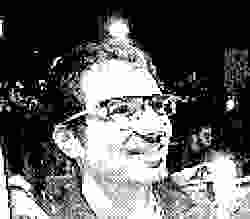

In [36]:
from IPython.display import Image
Image("headshot.png")


### Then If Happy They Contribute Their Master Secret and Request The Completion of the Signature

In [13]:
await agent_controller.issuer.send_request_for_record(record_id)

{'auto_remove': False,
 'initiator': 'external',
 'schema_id': 'TDAbSf3Uqebg8N4XvybMbg:2:GMC Licence:0.0.1',
 'role': 'holder',
 'credential_proposal_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/issue-credential/1.0/propose-credential',
  '@id': '043b4b3a-eca3-405d-a947-5c9c656228bd',
  'cred_def_id': 'TDAbSf3Uqebg8N4XvybMbg:3:CL:12:default',
  'credential_proposal': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/issue-credential/1.0/credential-preview',
   'attributes': [{'name': 'GMC Number', 'value': '1231231'},
    {'name': 'Responsible Officer GMC Number', 'value': '3827123'},
    {'name': 'Licenced From', 'value': '2021-05-18'},
    {'name': 'Re-Validation Due', 'value': '2026-05-17'},
    {'name': 'Name', 'value': 'Will A'},
    {'name': 'Headshot',
     'value': 'adsssssssssssssssssssssssssssssssllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllddddddddddddddddddddddddddddddddddddsssssssssssssssssssssssssssssggggggggg


---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 06f7b4c2-63aa-4247-bb95-c2213fc5a467
Credential exchange ID : 6d31cee3-0ad5-4f65-a388-0f27f0d0a1f0
Agent Protocol Role :  holder
Protocol State :  request_sent

---------------------------------------------------

Handle Credential Webhook Payload

A credential request object contains the commitment to the agents master secret using the nonce from the offer

---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : 06f7b4c2-63aa-4247-bb95-c2213fc5a467
Credential exchange ID : 6d31cee3-0ad5-4f65-a388-0f27f0d0a1f0
Agent Protocol Role :  holder
Protocol State :  credential_received

---------------------------------------------------

Handle Credential Webhook Payload
Received Credential


In [11]:
await agent_controller.issuer.remove_record(record_id)

{}

## Store Received Credential

This will be done automatically if the ACAPY_AUTO_STORE_CREDENTIAL=true flag is set in the .env file for this agent. Default is false.

Again you could handle this in your holder handler function in the `elif state == "credential_received":` loop.

In [14]:
# Optionally specify an identifier to uniquely identify this credential within your agents wallet.
# You would likely want to save this somewhere.
# If not set a random one will be generated for you
credential_id = "GMC4"

store_cred_response = await agent_controller.issuer.store_credential(record_id, credential_id)

ClientResponseError: 500, message='Internal Server Error', url=URL('http://medic-agent:3021/issue-credential/records/6d31cee3-0ad5-4f65-a388-0f27f0d0a1f0/store')

Error during POST /issue-credential/records/6d31cee3-0ad5-4f65-a388-0f27f0d0a1f0/store: 500, message='Internal Server Error', url=URL('http://medic-agent:3021/issue-credential/records/6d31cee3-0ad5-4f65-a388-0f27f0d0a1f0/store')


## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [102]:
await agent_controller.terminate()